In [1]:
from pathlib import Path
import json

import numpy as np

import pandas as pd
import geopandas as gpd

import wandb

from itertools import chain

import torch
from torch.utils.data import DataLoader

from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint


from src.dataset_preload import  TriDataset
from src.bsinet_gateless import BsiNet
from src.bsinet_pl import LightningModel
from src.losses import (
    LossBsiNet,
    LossBsiNetDice,
)   
from src.tools import show_samples
from src.tools import Rot90Flips
from src.tools import training_loop
from src.tools import validate_test
from src.tools import get_rpg_patches
from src.tools import get_ai4s_patches
from src.tools import get_AdamWMultiStep
from src.tools import get_AdamWOneCycle


# Data

In [2]:
def get_datasets(image_paths, 
                 mask_paths, 
                 distance_paths, 
                 extent_band, 
                 border_band, 
                 distance_band, 
                 min_max, 
                 data_augmentations=None):
    print('Loading datasets')

    train_dataset = TriDataset(
        image_paths['train'],
        mask_paths['train'],
        distance_paths['train'],
        extent_band=extent_band,
        border_band=border_band,        
        distance_band=distance_band,
        augmentation=data_augmentations,
        normalize=min_max,
    )
    
    valid_dataset = TriDataset(
        image_paths['validate'],
        mask_paths['validate'], 
        distance_paths['validate'],
        extent_band=extent_band,
        border_band=border_band,        
        distance_band=distance_band,
        normalize=min_max,
    )

    test_dataset = TriDataset(
        image_paths['test'],
        mask_paths['test'], 
        distance_paths['test'],
        extent_band=extent_band,
        border_band=border_band,        
        distance_band=distance_band,
        normalize=min_max,
    )

    print(f"Train size: {len(train_dataset)}")
    print(f"Valid size: {len(valid_dataset)}")
    print(f"Test size: {len(test_dataset)}")
    return train_dataset, valid_dataset, test_dataset

def get_loaders(train_dataset, valid_dataset, test_dataset, batch_size, n_cpu):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_cpu)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_cpu)
    return train_dataloader, valid_dataloader, test_dataloader

# Model

## Adapting model with optimizer and scheduler

In [3]:
AdamWMultiStep = get_AdamWMultiStep(LightningModel, milestones=[20,40,60,80], gamma = 0.3)
AdamWOneCycle = get_AdamWOneCycle(LightningModel)

# Training End

In [4]:
def send_images(model, logger, test_dataloader):
    
    batch = next(iter(test_dataloader))
    with torch.no_grad():
        model.eval()
        logits = model(batch["image"])


    preds = {'extent': (logits[0].sigmoid()>0.5).float(),
             'border': (logits[1].sigmoid()>0.5).float(),
             'distance': logits[2]
             }
    

    nb_samples = 25
    images = batch['image'][:nb_samples][:,:3]
    columns = ['image', 'ground truth', 'prediction', 'id']
    data = [
        [[wandb.Image(x.type(torch.FloatTensor)) for x in (image, gt, pred)]+[id, key] # one row = 3 pictures (image, gt, pred) and 1 id
         for image, gt, pred, id in zip(images, batch[key][:,-1], preds[key][:,-1], batch['id'])] # all rows for one key of mask, contour, distance
         for key in ('extent', 'border', 'distance')
         ]
    
    data = pd.DataFrame(chain(*data), columns=['image', 'gt', 'pred', 'id', 'key']).sort_values(['id', 'key'])
    logger.log_table(
        key='test_samples',
        columns=columns,
        data=data) 
    
    wandb.finish()

# Configuration

## Choices

In [5]:
# mask_bands for DS_RPG_SPOT

mask_bands_rpg = {'semantic_parcel_norm':[0,3,2], 
            'semantic_parcel_relative': [0,3,0],
            #'semantic_group_norm' : [0,4,3],
            #'semantic_group_relative': [0,4,1],
            #'interior_parcel_norm': [5,3,2],
            #'interior_parcel_relative': [5,3,0],
            #'interior_group_norm': [6,4,3],
            #'interior_group_relative': [6,4,1]
}
# mask_bands for AI4SmallFarms  
mask_bands_ai4s = {
    'distance_norm':[0,2,1], 
    'distance_relative':[0,2,0],
}
losses = {'LossBsiNet':LossBsiNet(num_classes=2),
#          'LossBsiNetExtent': LossBsiNet(num_classes=2, weights=[1,0,0]),
#          'LossBsiNetBorder': LossBsiNet(num_classes=2, weights=[0,1,0]),
#          'LossBsiNetDistance': LossBsiNet(num_classes=2, weights=[0,0,1]),
            'LossBsiNetDice': LossBsiNetDice()
          }

splits =  ['train', 'validate', 'test']
image_types = ['image', 'mask', 'distance']


## Static

### Dataset

In [6]:
# test datasets are smaller to allow for fast runs to check everything works
dataset_configs = {
                'RPG':  get_rpg_patches('../patches/') | {'bands': mask_bands_rpg},
                 'AI4S': get_ai4s_patches('../ai4smallfarms/patches/') | {'bands': mask_bands_ai4s},
                 'RPG_test':  get_rpg_patches('../patches/', sample=200) | {'bands': mask_bands_rpg},
                 'AI4S_test':  get_ai4s_patches('../ai4smallfarms/patches/', sample=200) | {'bands': mask_bands_ai4s},
                 }

In [8]:
data_aug = True
data_augmentations = Rot90Flips() if data_aug else None


# this is where the project will be logged on wandb
project_name = 'ai4_bsinet_gateless_scrap'

# number of CPU cores used for the dataloaders
n_cpu = 6

batch_size = 16
max_epochs = 3
lr = 0.001

opti_name = 'AdamW'
scheduler_name = 'MultiStepLR'

labels = ['image', 'extent', 'border', 'distance']

In [ ]:
dataset_choice = 'RPG_test'
config = dataset_configs[dataset_choice]
paths = config['paths']
min_max = config['min_max']
bands = config['bands']

In [9]:
hyperparameters = {'data_aug':data_aug, 
                                  'batch_size':batch_size, 
                                  'optimizer':opti_name, 'lr_scheduler':scheduler_name,
                                  'task':None,
                                  'loss':None
                                  }
def get_callbacks():
    early_stopping = EarlyStopping(monitor='valid_border_iou', patience=20, mode='max')
    model_checkpoint = ModelCheckpoint(monitor='valid_border_iou', mode='max', save_top_k=1)
    callbacks = [early_stopping, model_checkpoint]
    return callbacks

# Run all (comment if you want to run only one)

In [10]:
def run_all():
    n_models = np.prod([len(x) for x in [bands, losses]])
    i = 0
    for task, (extent_band, border_band, distance_band) in bands.items():
        train_dataset, valid_dataset, test_dataset = get_datasets(paths['image'], 
                                                            paths['mask'],
                                                            paths['distance'], 
                                                            extent_band,
                                                            border_band,
                                                            distance_band,
                                                            min_max, 
                                                            data_augmentations)

        train_dataloader, valid_dataloader, test_dataloader = get_loaders(train_dataset, 
                                                                        valid_dataset, 
                                                                        test_dataset, 
                                                                        batch_size, 
                                                                        n_cpu)
        for loss_name, loss in losses.items():
            hyperparameters['task'] = task
            hyperparameters['loss'] = loss_name
            callbacks = get_callbacks()
            net = BsiNet(input_channels=4, num_classes=2)
            model = AdamWMultiStep(net, loss, lr)
            i+=1
            print(f'Model {i:02}/{n_models}')
            model, trainer, logger = training_loop(model, 
                                                train_dataloader, 
                                                valid_dataloader, 
                                                project_name, 
                                                max_epochs, 
                                                hyperparameters, 
                                                callbacks)
            
            # load best checkpoint
            model = AdamWMultiStep.load_from_checkpoint(callbacks[1].best_model_path, model=net, loss=loss, lr=lr)
            validate_test(model, trainer, valid_dataloader, test_dataloader)
            send_images(model, logger, test_dataloader)
run_all()
exit()

Loading datasets
Train size: 157
Valid size: 14
Test size: 29
Model 01/4


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: quentin-yeche (quentin-yeche-phd). Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | BsiNet | 7.8 M 
---------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.388    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation metrics
[{'losss': 1.4784444570541382,
  'valid_border_f1_score': 0.0,
  'valid_border_iou': 0.0,
  'valid_extent_f1_score': 0.5549354553222656,
  'valid_extent_iou': 0.38402122259140015}]
Test metrics


Testing: |          | 0/? [00:00<?, ?it/s]

[{'losss': 1.452951192855835,
  'test_border_f1_score': 0.0,
  'test_border_iou': 0.0,
  'test_extent_f1_score': 0.6336512565612793,
  'test_extent_iou': 0.4637551009654999}]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Model 02/4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | BsiNet | 7.8 M 
---------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.388    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation metrics
[{'losss': 0.8913800716400146,
  'valid_border_f1_score': 0.0,
  'valid_border_iou': 0.0,
  'valid_extent_f1_score': 0.5549354553222656,
  'valid_extent_iou': 0.38402122259140015}]
Test metrics


Testing: |          | 0/? [00:00<?, ?it/s]

[{'losss': 0.9165104031562805,
  'test_border_f1_score': 0.0,
  'test_border_iou': 0.0,
  'test_extent_f1_score': 0.6336512565612793,
  'test_extent_iou': 0.4637551009654999}]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Loading datasets
Train size: 157
Valid size: 14
Test size: 29
Model 03/4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | BsiNet | 7.8 M 
---------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.388    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation metrics
[{'losss': 1.5125128030776978,
  'valid_border_f1_score': 0.09157009422779083,
  'valid_border_iou': 0.04798189923167229,
  'valid_extent_f1_score': 0.5549354553222656,
  'valid_extent_iou': 0.38402122259140015}]
Test metrics


Testing: |          | 0/? [00:00<?, ?it/s]

[{'losss': 1.4830816984176636,
  'test_border_f1_score': 0.08846686035394669,
  'test_border_iou': 0.04628057777881622,
  'test_extent_f1_score': 0.6336512565612793,
  'test_extent_iou': 0.4637551009654999}]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Model 04/4


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | BsiNet | 7.8 M 
---------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.388    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation metrics
[{'losss': 1.3190407752990723,
  'valid_border_f1_score': 0.002050939714536071,
  'valid_border_iou': 0.0010265224846079946,
  'valid_extent_f1_score': 0.5549354553222656,
  'valid_extent_iou': 0.38402122259140015}]
Test metrics


Testing: |          | 0/? [00:00<?, ?it/s]

[{'losss': 1.2968686819076538,
  'test_border_f1_score': 0.003724071430042386,
  'test_border_iou': 0.0018655093153938651,
  'test_extent_f1_score': 0.6336512565612793,
  'test_extent_iou': 0.4637551009654999}]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


# One Model

## Making choices

In [11]:
task = 'semantic_parcel_norm'
task = 'distance_norm'
extent_band, border_band, distance_band = bands[task]
hyperparameters['task'] = task

loss_name = 'LossBsiNet'
loss = losses[loss_name]
hyperparameters['loss'] = loss_name



KeyError: 'distance_norm'

: 

## Datasets & Loaders

Loading datasets


Train size: 137
Valid size: 35
Test size: 28


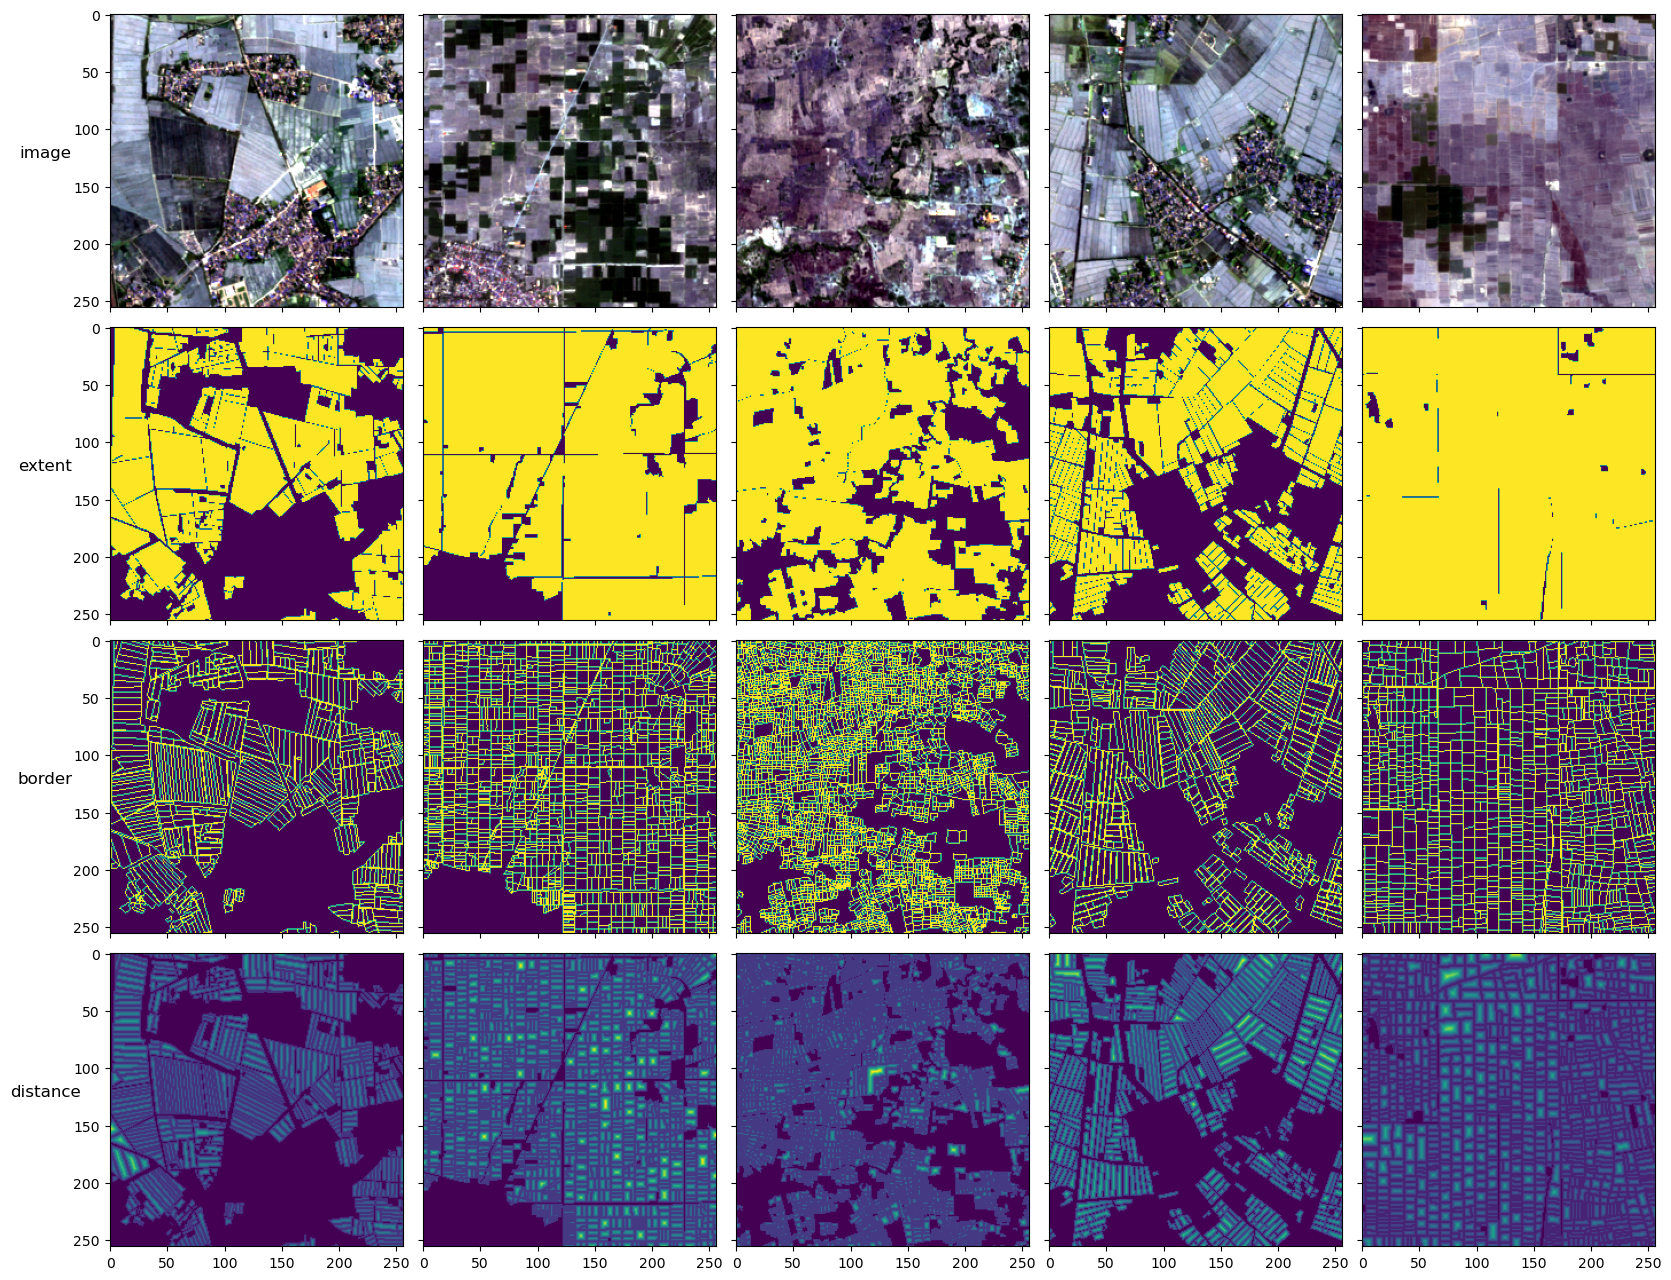

In [ ]:
train_dataset, valid_dataset, test_dataset = get_datasets(paths['image'], 
                                                    paths['mask'],
                                                    paths['distance'], 
                                                    extent_band,
                                                    border_band,
                                                    distance_band,
                                                    min_max, 
                                                    data_augmentations)

train_dataloader, valid_dataloader, test_dataloader = get_loaders(train_dataset, 
                                                                valid_dataset, 
                                                                test_dataset, 
                                                                batch_size, 
                                                                n_cpu)

show_samples(train_dataloader, labels=labels, nb_samples = 5)


## Training

In [ ]:
net = BsiNet(input_channels=4, num_classes=2)
model = AdamWMultiStep(net, loss, lr)
callbacks = get_callbacks()

In [ ]:
model, trainer, logger = training_loop(model, 
                                       train_dataloader, 
                                       valid_dataloader, 
                                       project_name, 
                                       max_epochs, 
                                       hyperparameters, 
                                       callbacks)

model = AdamWMultiStep.load_from_checkpoint(callbacks[1].best_model_path, model=net, loss=loss, lr=lr)
validate_test(model, trainer, valid_dataloader, test_dataloader)
send_images(model, logger, test_dataloader)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: quentin-yeche (quentin-yeche-phd). Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | BsiNet | 7.8 M 
---------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.389    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/home/quentin/miniforge3/envs/ds_rpg_spot/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation metrics
[{'losss': 1.417622447013855,
  'valid_border_f1_score': 0.0,
  'valid_border_iou': 0.0,
  'valid_extent_f1_score': 0.8676912188529968,
  'valid_extent_iou': 0.7663026452064514}]
Test metrics


Testing: |          | 0/? [00:00<?, ?it/s]

[{'losss': 1.4049677848815918,
  'test_border_f1_score': 0.0,
  'test_border_iou': 0.0,
  'test_extent_f1_score': 0.8831754922866821,
  'test_extent_iou': 0.7907916903495789}]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
